In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [77]:
data = pd.read_csv('Reviews.csv')

In [78]:
print(data.shape)
data.head()

(568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [79]:
data.dtypes

Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
dtype: object

# Text PreProcessing

In [5]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [80]:
total = []
for i in range(0, 20000):
    review = re.sub('[^a-zA-Z]', ' ', data['Text'][i])
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    total.append(review)

In [81]:
total = pd.DataFrame(total, columns=['Reviews']) 
total.head()

,Reviews
0,bought sever vital can dog food product found ...
1,product arriv label jumbo salt peanut peanut a...
2,confect around centuri light pillowi citru gel...
3,look secret ingredi robitussin believ found go...
4,great taffi great price wide assort yummi taff...


In [82]:
result = corpus.join(df[['Score']])
result.head()

,Reviews,Score
0,bought sever vital can dog food product found ...,5
1,product arriv label jumbo salt peanut peanut a...,1
2,confect around centuri light pillowi citru gel...,4
3,look secret ingredi robitussin believ found go...,2
4,great taffi great price wide assort yummi taff...,5


# TF-IDF Technique

In [88]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
tfidf.fit(result['Reviews'])

TfidfVectorizer()

In [89]:
X = tfidf.transform(result['Reviews'])
result['Reviews']

0        bought sever vital can dog food product found ...
1        product arriv label jumbo salt peanut peanut a...
2        confect around centuri light pillowi citru gel...
3        look secret ingredi robitussin believ found go...
4        great taffi great price wide assort yummi taff...
                               ...                        
19995    deep river salt vinegar chip thick crunchi tar...
19996    skeptic buy brand chip never tast much less bu...
19997    turn name brand give tri although maui onion b...
19998    expect seriou flavor advertis bag compar jalap...
19999    purchas salt vinegar chip pleas right amount v...
Name: Reviews, Length: 20000, dtype: object

# Sentiment Classification

In [90]:
result.dropna(inplace=True)
result[result['Score'] != 3]
result['Positivity'] = np.where(result['Score'] > 3, 1, 0)
cols = [ 'Score']
result.drop(cols, axis=1, inplace=True)
result.head()

,Reviews,Positivity
0,bought sever vital can dog food product found ...,1
1,product arriv label jumbo salt peanut peanut a...,0
2,confect around centuri light pillowi citru gel...,1
3,look secret ingredi robitussin believ found go...,0
4,great taffi great price wide assort yummi taff...,1


In [91]:
result.groupby('Positivity').size()

Positivity
0     4593
1    15407
dtype: int64

# Splitting the Data : Train-test

In [92]:
from sklearn.model_selection import train_test_split
X = result.Reviews
y = result.Positivity
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [93]:
from tabulate import tabulate
data = [["Training Set", (len(X_train[y_train == 0])/(len(X_train)*1.))*100,(len(X_train[y_train == 1])/(len(X_train)*1.))*100],
        ["Testing Set", (len(X_test[y_test == 0])/(len(X_test)*1.))*100,(len(X_test[y_test == 1])/(len(X_test)*1.))*100]]
print (tabulate(data, headers=[" ", "Negative", "Positive"]))

                Negative    Positive
------------  ----------  ----------
Training Set       22.62       77.38
Testing Set        24          76


In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [17]:
def accuracy_summary(pipeline, X_train, y_train, X_test, y_test):
    sentiment_fit = pipeline.fit(X_train, y_train)
    y_pred = sentiment_fit.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    return accuracy

In [18]:
cv = CountVectorizer()
rf = RandomForestClassifier(class_weight="balanced")
n_features = np.arange(10000,30001,5000)

def nfeature_accuracy_checker(vectorizer=cv, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=rf):
    result = []
    print(classifier)
    print("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print("Test result for {} features".format(n))
        nfeature_accuracy = accuracy_summary(checker_pipeline, X_train, y_train, X_test, y_test)
        result.append((n,nfeature_accuracy))
    return result

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

In [20]:
print("Result for trigram with stop words (Tfidf)\n")
feature_result_tgt = nfeature_accuracy_checker(vectorizer=tfidf,ngram_range=(1, 3))

Result for trigram with stop words (Tfidf)

RandomForestClassifier(class_weight='balanced')


Test result for 10000 features
accuracy score: 84.34%
Test result for 15000 features
accuracy score: 84.04%
Test result for 20000 features
accuracy score: 83.84%
Test result for 25000 features
accuracy score: 83.84%
Test result for 30000 features
accuracy score: 83.76%


In [21]:
from sklearn.metrics import classification_report

cv = CountVectorizer(max_features=30000,ngram_range=(1, 3))
pipeline = Pipeline([
        ('vectorizer', cv),
        ('classifier', rf)
    ])
sentiment_fit = pipeline.fit(X_train, y_train)
y_pred = sentiment_fit.predict(X_test)
print("The accuracy score for CV as vectorizer" + str(accuracy_score( y_test, y_pred)))

print(classification_report(y_test, y_pred, target_names=['negative','positive']))

The accuracy score for CV as vectorizer0.8372
              precision    recall  f1-score   support

    negative       0.88      0.37      0.52      1200
    positive       0.83      0.98      0.90      3800

    accuracy                           0.84      5000
   macro avg       0.86      0.68      0.71      5000
weighted avg       0.84      0.84      0.81      5000



In [63]:
from sklearn.metrics import plot_confusion_matrix

/Users/seepanas10/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


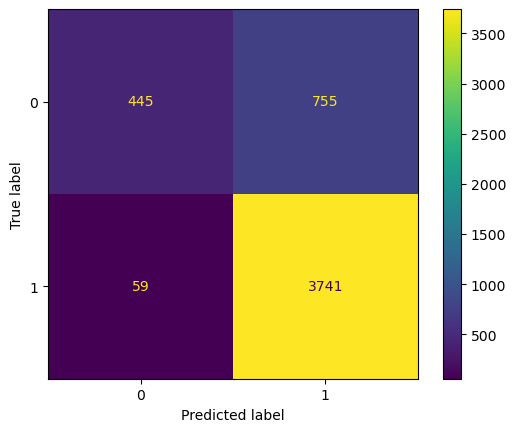

In [68]:
plot_confusion_matrix(sentiment_fit,X_test,y_test)

In [22]:
## K-fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = pipeline, X= X_train, y = y_train,
                             cv = 10)
print("Random Forest Classifier Accuracy: %0.2f (+/- %0.2f)"  % (accuracies.mean(), accuracies.std() * 2))

Random Forest Classifier Accuracy: 0.84 (+/- 0.02)


# LSTM Neural Network

In [40]:
import tensorflow as tf
import keras as keras
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.layers import SpatialDropout1D
import re

In [95]:
max_features = 30000
tokenizer = Tokenizer(num_words = max_features, split=' ')
tokenizer.fit_on_texts(result['Reviews'].values)
X1 = tokenizer.texts_to_sequences(result['Reviews'].values)
X1 = pad_sequences(X1)

In [96]:
Y1 = pd.get_dummies(result['Positivity']).values
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1,Y1, random_state = 42)
print(X1_train.shape,Y1_train.shape)
print(X1_test.shape,Y1_test.shape)

(15000, 1007) (15000, 2)
(5000, 1007) (5000, 2)


# Embedding Layer 

In [47]:
embed_dim = 100
lstm_out = 200

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X1.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(200, dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1007, 100)         3000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 1007, 100)        0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 200)               240800    
                                                                 
 dense (Dense)               (None, 2)                 402       
                                                                 
Total params: 3,241,202
Trainable params: 3,241,202
Non-trainable params: 0
_________________________________________________________________
None


2022-11-23 14:49:56.912840: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [49]:
batch_size = 32
model.fit(X1_train, Y1_train, epochs = 10, batch_size=batch_size, verbose = 2)

Epoch 1/10
469/469 - 692s - loss: 0.2772 - accuracy: 0.8875 - 692s/epoch - 1s/step
Epoch 2/10
469/469 - 643s - loss: 0.2007 - accuracy: 0.9234 - 643s/epoch - 1s/step
Epoch 3/10
469/469 - 703s - loss: 0.1508 - accuracy: 0.9426 - 703s/epoch - 1s/step
Epoch 4/10
469/469 - 630s - loss: 0.1105 - accuracy: 0.9582 - 630s/epoch - 1s/step
Epoch 5/10
469/469 - 631s - loss: 0.0890 - accuracy: 0.9672 - 631s/epoch - 1s/step
Epoch 6/10
469/469 - 699s - loss: 0.0716 - accuracy: 0.9739 - 699s/epoch - 1s/step
Epoch 7/10
469/469 - 1007s - loss: 0.0549 - accuracy: 0.9803 - 1007s/epoch - 2s/step
Epoch 8/10
469/469 - 632s - loss: 0.0518 - accuracy: 0.9820 - 632s/epoch - 1s/step
Epoch 9/10
469/469 - 774s - loss: 0.0395 - accuracy: 0.9859 - 774s/epoch - 2s/step
Epoch 10/10
469/469 - 656s - loss: 0.0347 - accuracy: 0.9891 - 656s/epoch - 1s/step


In [51]:
score,acc = model.evaluate(X1_test, Y1_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

157/157 - 44s - loss: 0.8327 - accuracy: 0.8492 - 44s/epoch - 282ms/step
score: 0.83
acc: 0.85


In [53]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X1_test)):
    
    result = model.predict(X1_test[x].reshape(1,X1_test.shape[1]),batch_size=1,verbose = 0)[0]
   
    if np.argmax(result) == np.argmax(Y1_test[x]):
        if np.argmax(Y1_test[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y1_test[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

pos_acc 92.1327757449033 %
neg_acc 61.41396933560477 %
